In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import optax
from jax.typing import ArrayLike

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'true'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = '0.3'

from pulse_optimization import Simulation
import pulses_shapes as ps

In [2]:
MHz = 2 * jnp.pi
kHz = 2 * jnp.pi * 1e-3
us = 1.0
ns = 1.0e-3

In [10]:
Na, Nb = 20, 9

nbar_max = 4
nbar_0 = 4

kappa_a = 1 / (10 * us)
kappa_b = 15 * MHz
g2 = 2 * MHz
ed_max = -nbar_max * g2
gl_max = g2 / 2

t_max = 1 * us
N_tpulse = int(t_max // (10 * ns)) + 1
tpulse = jnp.linspace(0, t_max, N_tpulse)
N_tsave = 1001
tsave = jnp.linspace(0, t_max, N_tsave)
a, b = dq.destroy(Na, Nb)

In [11]:
def constant_term(term: ArrayLike) -> ArrayLike:
    return lambda *_: term

In [12]:
def pwc_term(h_term: ArrayLike) -> ArrayLike:
    def H_func(tpulse: ArrayLike, pulse: ArrayLike):
        H = dq.pwc(tpulse, pulse, h_term)
        H += dq.pwc(tpulse, jnp.conj(pulse), dq.dag(h_term))
        return H

    return H_func

In [13]:
hamiltonian_terms = {
    "h2": pwc_term(g2 * a @ a @ dq.dag(b)),
    # "hd_re": pwc_term(ed_max * b),
    # "hd_im": pwc_term(1j * ed_max * b),
    "hd_fft": pwc_term(ed_max * b),
}
jump_operators = {
    "la": constant_term(jnp.sqrt(kappa_a) * a),
    "lb": constant_term(jnp.sqrt(kappa_b) * b),
}

In [14]:
pulse_functions = {
    'la': lambda t, p: p,
    'lb': lambda t, p: p,
    'h2': lambda t, p: p,
    # 'hd_re': lambda t, p: p,
    # 'hd_im': lambda t, p: p,
    'hd_fft': ps.pulse_from_fft_free_fundamental,
}

In [15]:
hd_fft_weights = np.zeros(1 + 15*2, dtype=jnp.float32)
hd_fft_weights[0] = 200*ns
hd_fft_weights[1] = -0.5
pulse_params = {
    "h2": jnp.ones(N_tpulse - 1, dtype=jnp.float32),
    # "hd_re": ps.random_normal_pulse(tpulse, 0, 0.1, 1),
    # "hd_im": ps.random_normal_pulse(tpulse, 0, 0.1, 1),
    # "hd_im": jnp.zeros(N_tpulse - 1, dtype=jnp.float32),
    # "hd_fft": ps.random_fft_weights(30, 0, 3.),
    "hd_fft": hd_fft_weights,
    "la": 1,
    "lb": 1,
}

In [16]:
alpha = jnp.sqrt(nbar_0)
cat_p = dq.unit(dq.coherent(Na, alpha) + dq.coherent(Na, -alpha))
cat_m = dq.unit(dq.coherent(Na, alpha) - dq.coherent(Na, -alpha))
rho_zeros = [dq.tensor(cat_p, dq.fock(Nb, 0)), dq.tensor(cat_m, dq.fock(Nb, 0))]

In [17]:
def cost_function(tsave, states, pulses) -> float:
    # max_abs_hd_pulse = jnp.max(jnp.abs(pulses['hd_re'] + 1j * pulses['hd_im']))
    max_abs_hd_pulse = jnp.max(jnp.abs(pulses['hd_fft']))
    cost_max = jax.nn.relu(max_abs_hd_pulse - 1)
    # cost_max = jnp.heaviside(max_abs_hd_pulse-1, 1) * (jnp.exp((max_abs_hd_pulse - 1) / 0.05) - 1)

    snr = jnp.sqrt(
        jnp.sum(jnp.abs(dq.expect(b, states[0]) - dq.expect(b, states[1])) ** 2)
        * tsave[1]
    )

    return -cost_max + snr

In [18]:
N_optimize = 200
to_optimize = ["hd_fft"]

simu = Simulation(
    cut_offs=(Na, Nb),
    hamiltonian_terms=hamiltonian_terms,
    jump_operators=jump_operators,
    pulse_functions=pulse_functions,
    rho_zeros=rho_zeros,
    tpulse=tpulse,
    tsave=tsave,
    to_optimize=to_optimize,
    pulse_params=pulse_params,
    cost_function=cost_function,
    N_optimize=N_optimize,
    exp_plot={"b": b},
    optimizer=optax.adam(1e-2),
)

100.00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| [00:04<00:00, 21.16%/s]


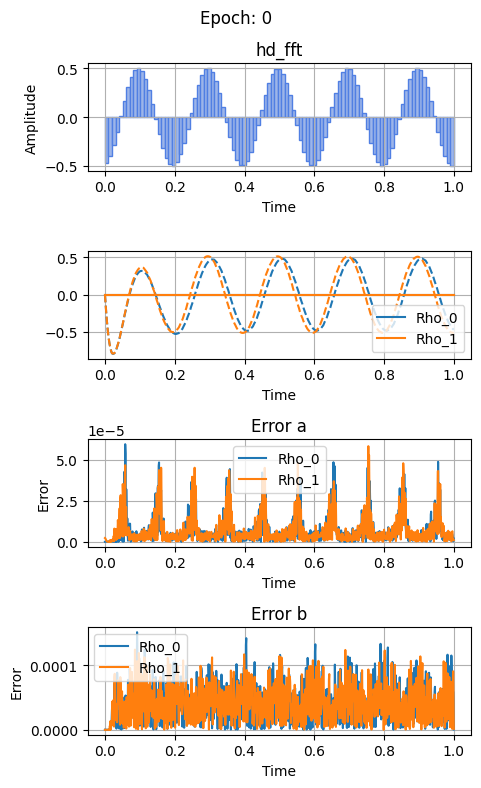

In [19]:
simu.plot_evolution();

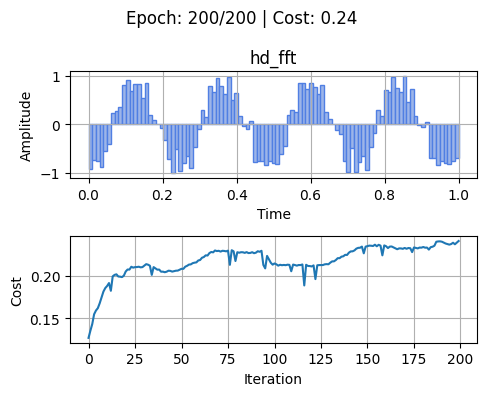

In [20]:
simu.optimize()

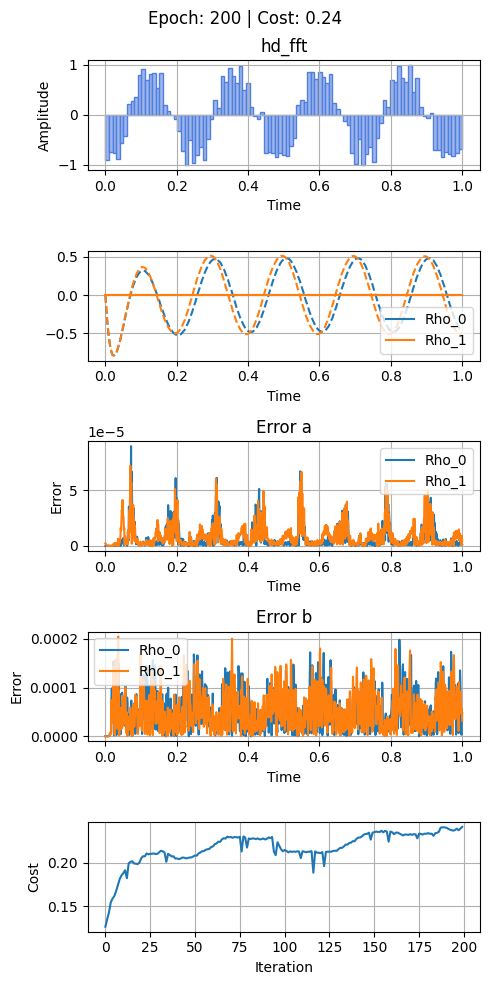

In [21]:
simu.plot_evolution();

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.58it/s]


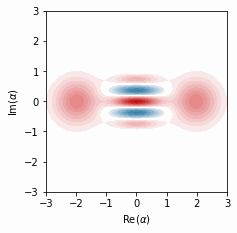

In [22]:
simu.plot_wigner_gif(ind_el=0, sub_system=0, xmax=3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.04it/s]


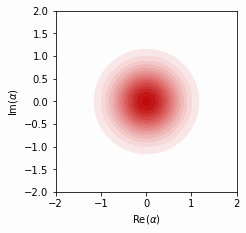

In [23]:
simu.plot_wigner_gif(ind_el=1, sub_system=1, xmax=2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.45it/s]


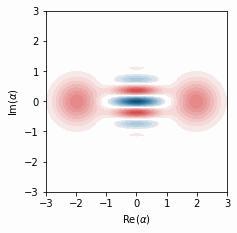

In [24]:
simu.plot_wigner_gif(ind_el=1, sub_system=0, xmax=3)

  0%|                                                                                                                                                                                                                      | 0/50 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.10it/s]


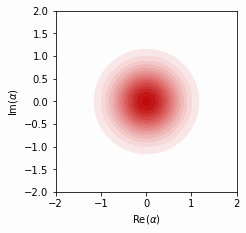

In [25]:
simu.plot_wigner_gif(ind_el=1, sub_system=1, xmax=2)

In [34]:
n_weight = len(simu.params_history[0]["hd_fft"])//2
fft_history = np.array([simu.params_history[i]["hd_fft"] for i in range(len(simu.params_history))])
fft_c = fft_history[:, 1:n_weight+1] + 1j*fft_history[:, n_weight+1:]
period_ns = fft_history[:, 0]

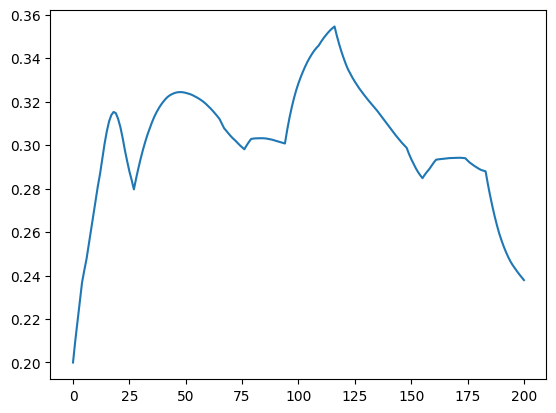

In [35]:
plt.plot(period_ns)

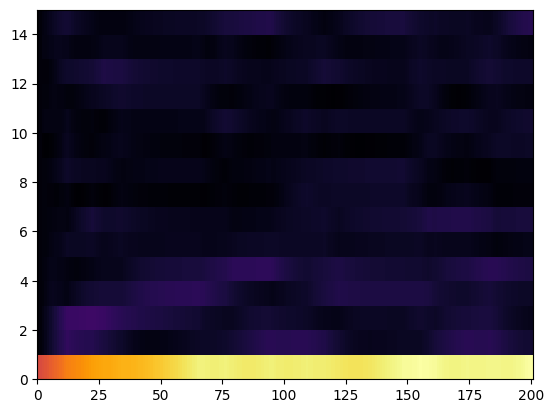

In [43]:
plt.pcolor(jnp.abs(fft_c.T), cmap="inferno")

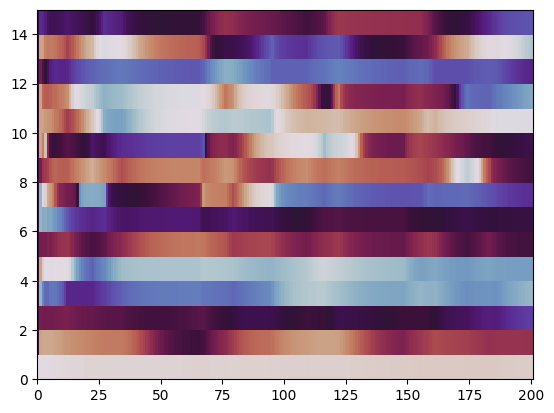

In [37]:
plt.pcolor(jnp.angle(fft_c.T), cmap="twilight")